In [2]:
%pip install gribscan
%pip install healpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import gribscan
import intake

#import os.path # necessary to check if file exists

In [3]:
import healpy


def get_nest(dx):
    return dx.crs.healpix_order == "nest"


def get_nside(dx):
    return dx.crs.healpix_nside


def attach_coords_icon(ds):
    lons, lats = healpy.pix2ang(
        get_nside(ds), np.arange(ds.dims["cell"]), nest=get_nest(ds), lonlat=True
    )
    return ds.assign_coords(
        lat=(("cell",), lats, {"units": "degree_north"}),
        lon=(("cell",), lons, {"units": "degree_east"}),
    )

In [4]:
def attach_coords(ds):
    model_lon = ds.lon.values
    model_lat = ds.lat.values
    return ds.assign_coords(
        lat = (("value",), model_lat, {"units": "degree_north"}),
        lon = (("value",), model_lon, {"units": "degree_east"}),
    )

In [5]:
cat = intake.open_catalog("https://nextgems.github.io/catalog/catalog.yaml")

In [6]:
# which IFS experiments are available? Which streams are in the IFS catalog for experiment 'tco2559-ng5-cycle3'?
print(list(cat.IFS))
print(list(cat.IFS['IFS_4.4-FESOM_5-cycle3'])) 

print(list(cat.ICON))

['IFS_4.4-FESOM_5-cycle3', 'IFS_9-FESOM_5-cycle3', 'IFS_9-NEMO_25-cycle3', 'IFS_28-NEMO_25-cycle3', 'IFS_28-FESOM_25-cycle3', 'IFS_grids']
['2D_1h_native', '3D_1h6h_native', '2D_monthly_native', '3D_monthly_native', '2D_monthly_0.25deg', '3D_monthly_0.25deg', '2D_monthly_1deg', '3D_monthly_1deg', 'WAM_1h_native']
['ngc3028']


In [12]:
array_yea= ["2020","2021","2022","2023","2024"]
array_mon= ["01","02","03","04","05","06","07","08","09","10","11","12"]

array_exp     = ["IFS_28-NEMO_25-cycle3","IFS_28-FESOM_25-cycle3","IFS_9-NEMO_25-cycle3","IFS_9-FESOM_5-cycle3","IFS_4.4-FESOM_5-cycle3"]
array_color   = ["cyan","magenta","blue","orange","red"]
array_labels  = ["Cycle 3, IFS 28 km, Nemo","Cycle 3, IFS 28 km, Fesom","Cycle 3, IFS 9 km, Nemo","Cycle 3, IFS 9 km, Fesom","Cycle 3, IFS 4.4 km, Fesom"]

In [8]:
dask_dict = {}
for a,exp in enumerate(array_exp):
    data = cat.IFS[f'{exp}']['2D_monthly_0.25deg'].to_dask().pipe(attach_coords)['tp'].groupby("lat").mean() # load medium-resolution here, monthly means (entire time series), zonal mean      
    month_idxs=data.groupby('time.month').groups
    for m in range(len(array_mon)):
        mon=m+1
        idxs=month_idxs[mon]
        dask_dict[a,m]=data.isel(time=idxs)    
  

In [9]:
ICON_dict = {}
data_ICON = cat.ICON['ngc3028'](zoom=5).to_dask().pipe(attach_coords_icon)['pr'].resample(time="1M").mean(dim="time").groupby("lat").mean() 

year_idxs_ICON=data_ICON.groupby('time.year').groups  

for y,year in enumerate(array_yea):
  idxs_year=year_idxs_ICON[int(year)] 
  data_ICON_year=data_ICON.isel(time=idxs_year)
  month_idxs_ICON=data_ICON_year.groupby('time.month').groups
  for m,mon in enumerate(array_mon):        
        idxs=month_idxs_ICON[int(mon)]
        ICON_dict[y,m]=data_ICON_year.isel(time=idxs) *86400 # from mm/s to mm/d

In [10]:
indir_GPM   = "/work/bm1235/observations/GPM_IMERG/"

PrG = {}
PrGclim = {}
for i,mon in enumerate(array_mon):
    file=f'{indir_GPM}/GPM_IMERG_hourly_2020_{mon}_timmean.nc'
    Pr = xr.open_dataset(file,engine='netcdf4')['precipitationCal'].load()
    Pr = np.mean(Pr[:,:],2) # average over all lons
    PrG[i] = np.squeeze(Pr) *24
    file=f'{indir_GPM}/GPM_IMERG_hourly_2010to2020_month_{mon}_timmean.nc'
    Pr = xr.open_dataset(file,engine='netcdf4')['precipitationCal'].load()
    Pr = np.mean(Pr[:,:],2) # average over all lons
    PrGclim[i] = np.squeeze(Pr) *24

01
02
03
04
05
06
07
08
09
10
11
12


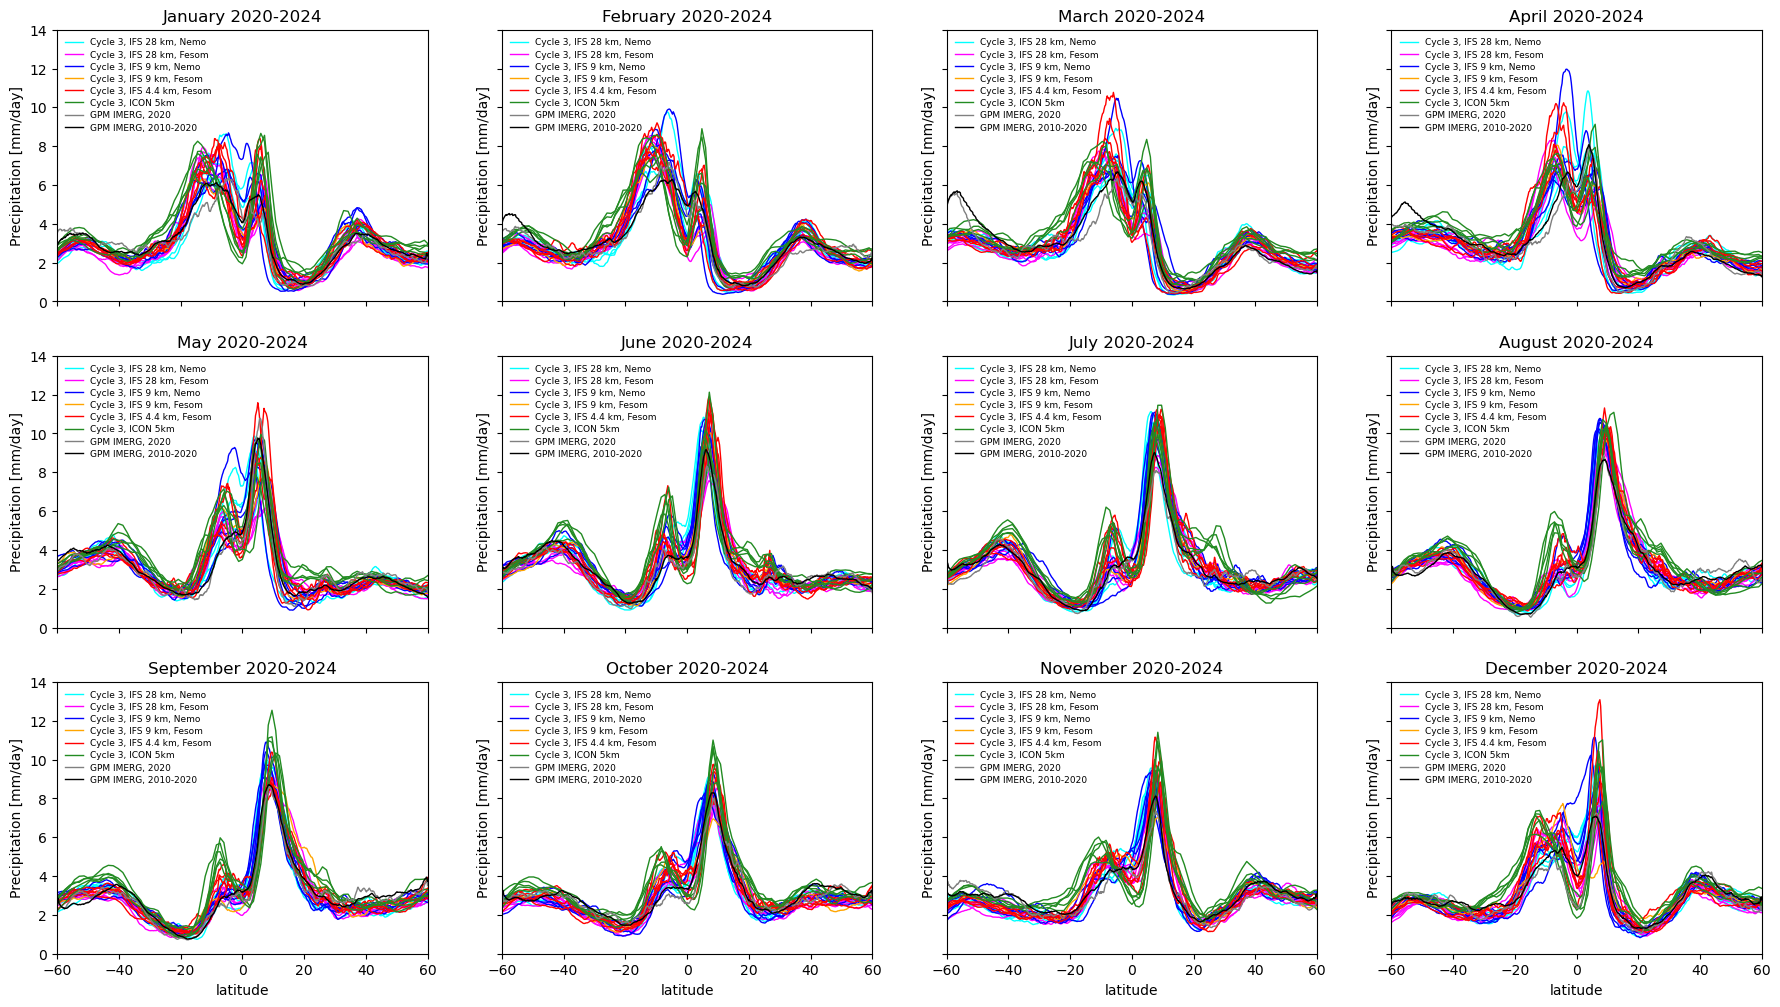

In [19]:
# calendar plot for all years in one
fig, axs = plt.subplots(3,4, figsize=(22, 12), sharex=True, sharey=True)


# set labels
plt.setp(axs[-1], xlabel='latitude') # only plot this for the last element
plt.setp(axs[:], ylabel='Precipitation [mm/day]')
plt.setp(axs[:], xlim=(-60, 60))
plt.setp(axs[:], ylim=(0, 14))
Title= ["January 2020-2024","February 2020-2024","March 2020-2024","April 2020-2024","May 2020-2024","June 2020-2024","July 2020-2024","August 2020-2024","September 2020-2024","October 2020-2024","November 2020-2024","December 2020-2024"]

for mon,(i,ax) in zip(array_mon,enumerate(axs.flat)):  
     print(mon)
     ax.set_title(Title[i])

     for (a,exp),color,labels in zip(enumerate(array_exp),array_color,array_labels):        
       filP = dask_dict[a,i] *1000 *86400 #transform from m/s in mm/day ; first dimension is experiment, second dimension is month
       for y in range(len(filP[:,0])):
           filP_y=np.squeeze(filP[y,:])
           if y>0:
               labels=""
           ax.plot(filP_y.lat,
                   filP_y,
                   color=color,
                   linestyle='solid',
                   label=labels,
                   linewidth=1)


     for (y,yea) in enumerate(array_yea):    
           ICON_y=np.squeeze(ICON_dict[y,i])
           labels="Cycle 3, ICON 5km"           
           if y>0:
               labels=""
           ax.plot(ICON_y.lat,
                   ICON_y,
                   color="forestgreen",
                   linestyle='solid',
                   label=labels,
                   linewidth=1)        
        
     ax.plot(PrG[i].lat,
          PrG[i],
          color="grey",
          linestyle='solid',
          label="GPM IMERG, 2020",
          linewidth=1)
     
     ax.plot(PrGclim[i].lat,
          PrGclim[i],
          color="black",
          linestyle='solid',
          label="GPM IMERG, 2010-2020",
          linewidth=1)    
     
     
     # Add legend
     handles, labels = ax.get_legend_handles_labels()
     ax.legend(handles,
          labels,
          loc='upper left',
          frameon=False,
          fontsize=6.5,
          labelspacing=.35)


#fig.savefig(f'../../../scripte_plots/panel12_precip_zonmean_NextGEMS_Cycle3_4km_9km_28km_ICON_GPM_allyears.png')  
#fig.savefig(f'../../../scripte_plots/panel12_precip_zonmean_NextGEMS_Cycle3_4km_9km_28km_ICON_GPM_allyears.pdf')  

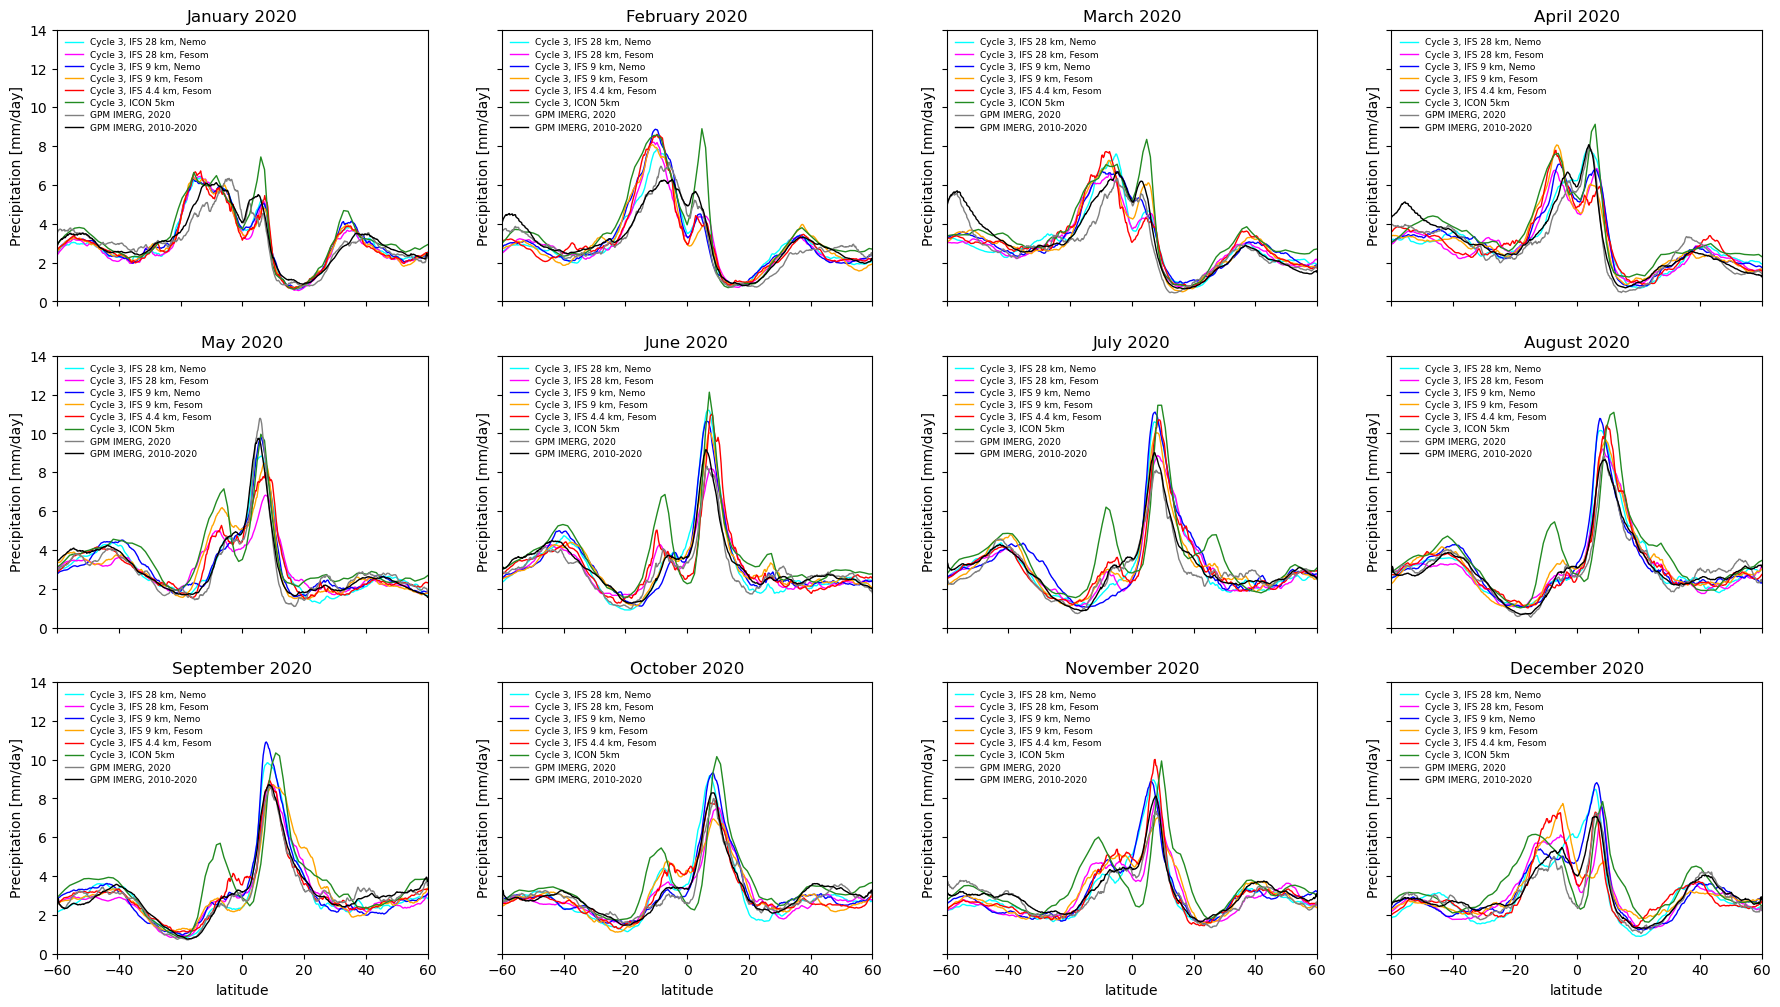

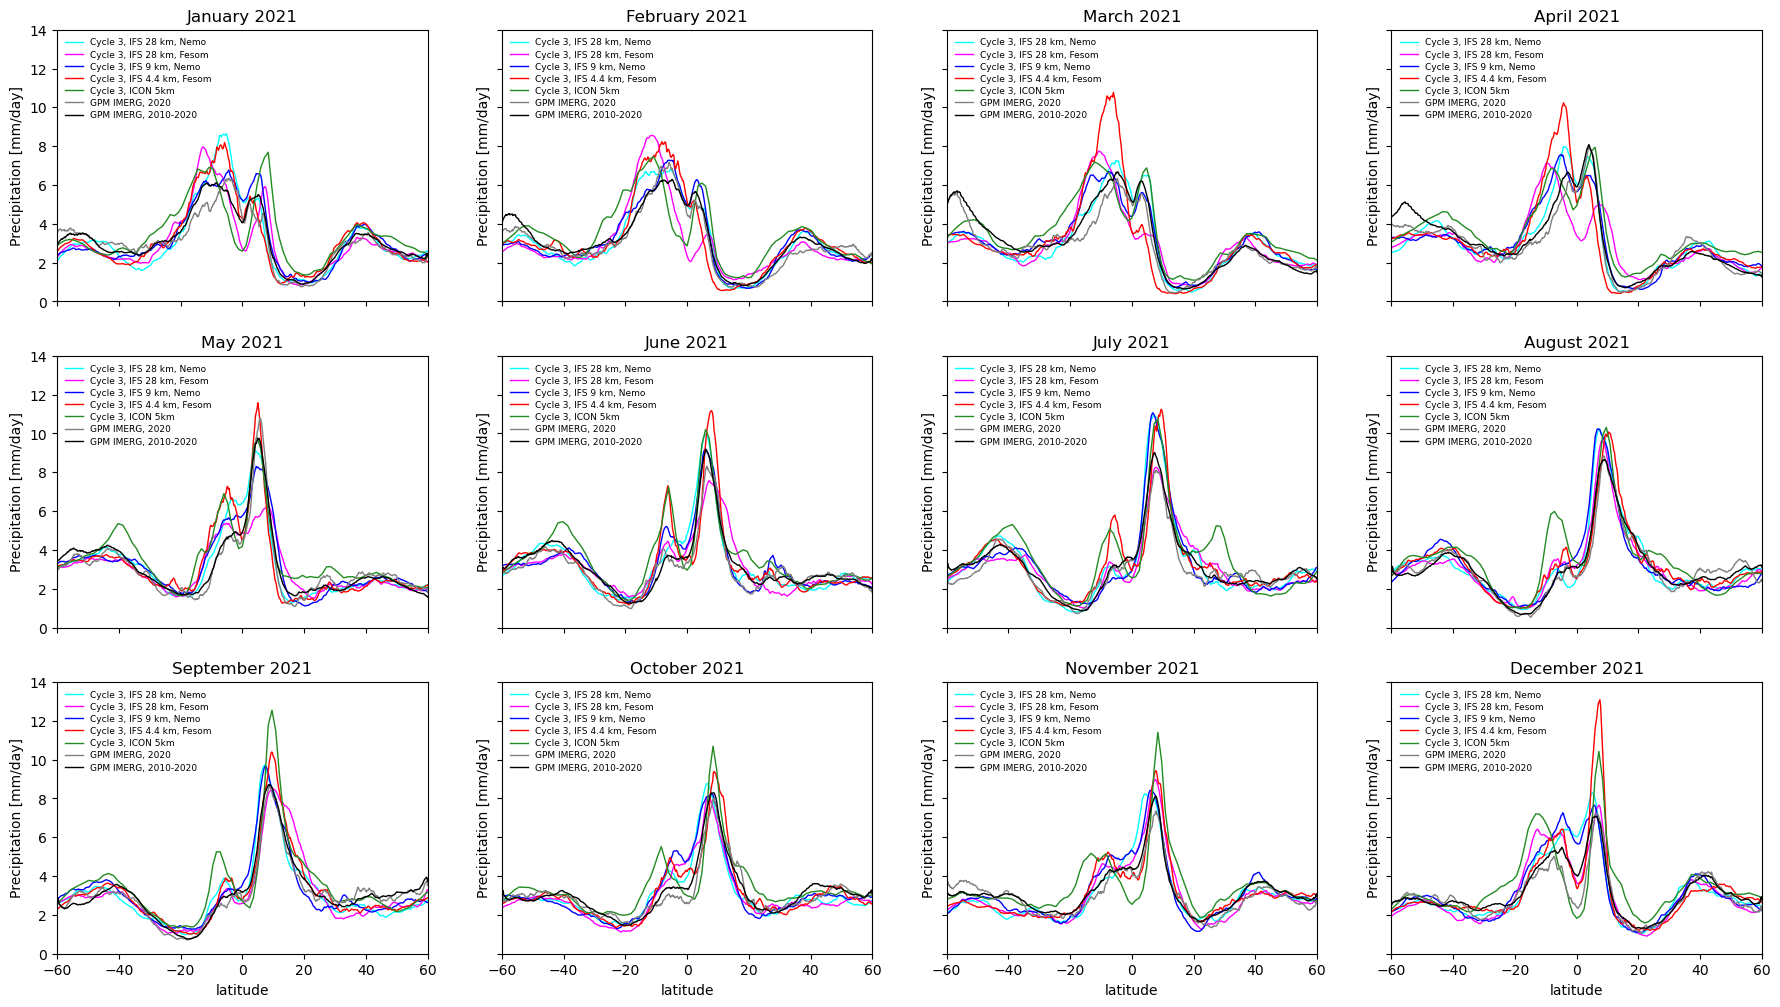

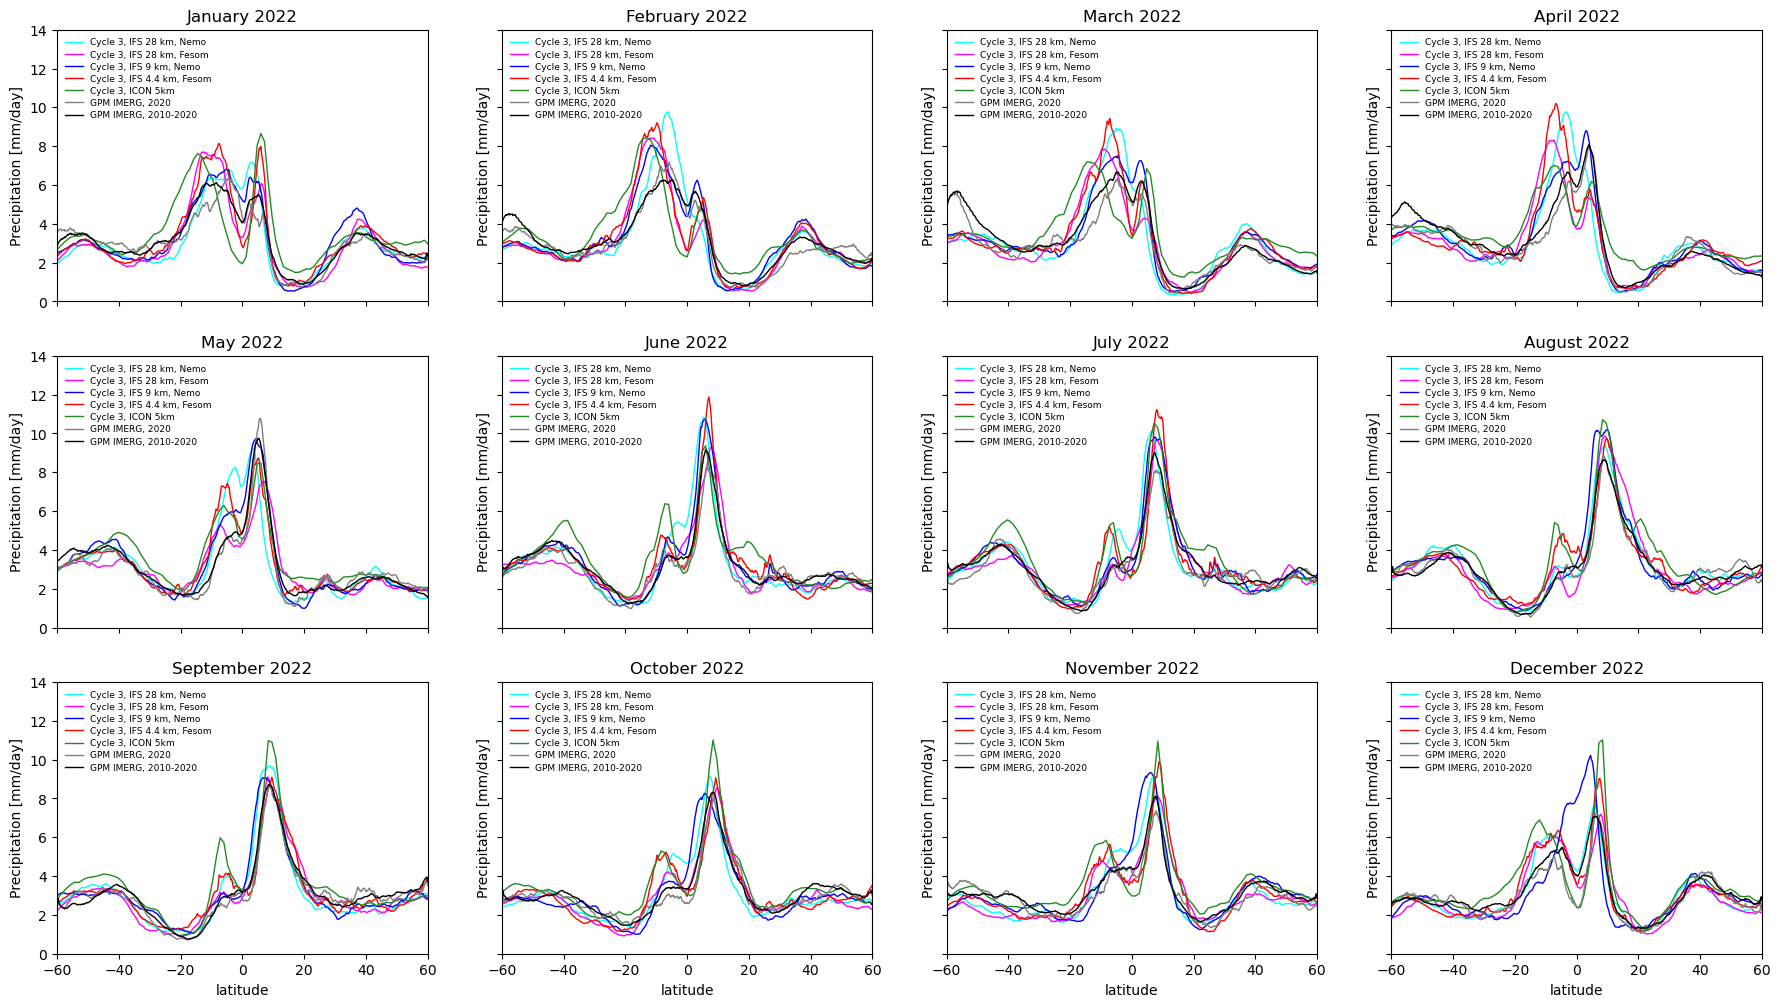

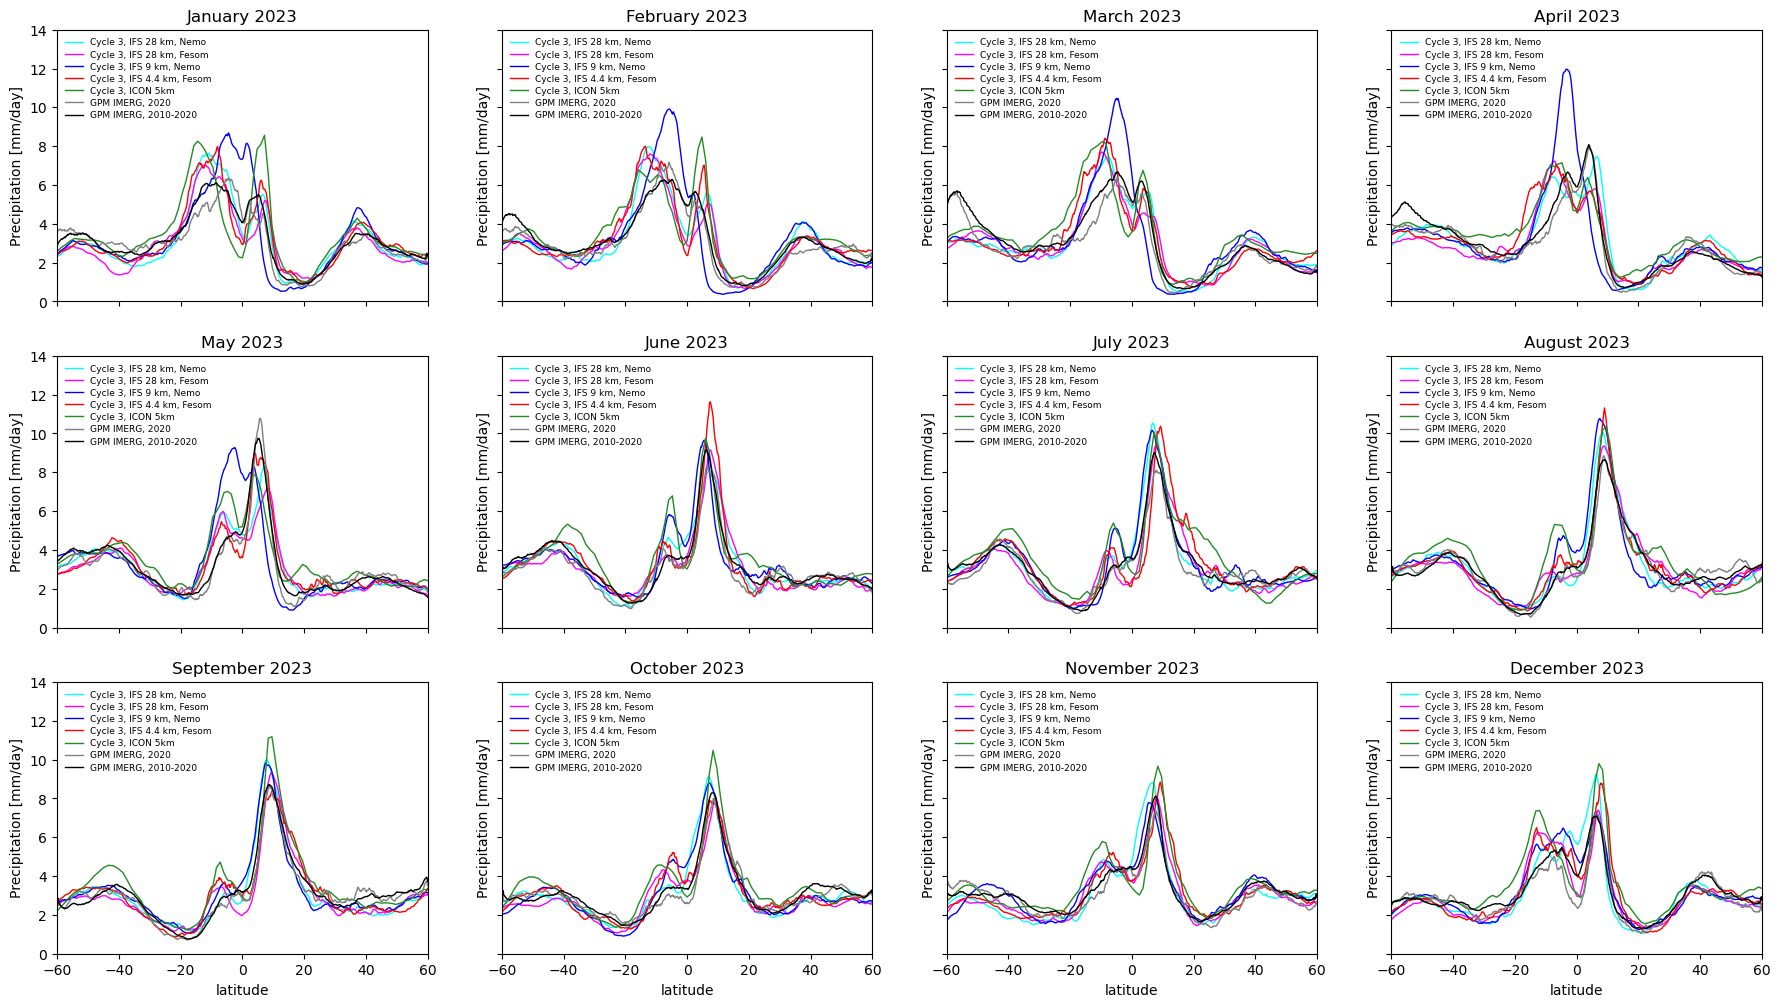

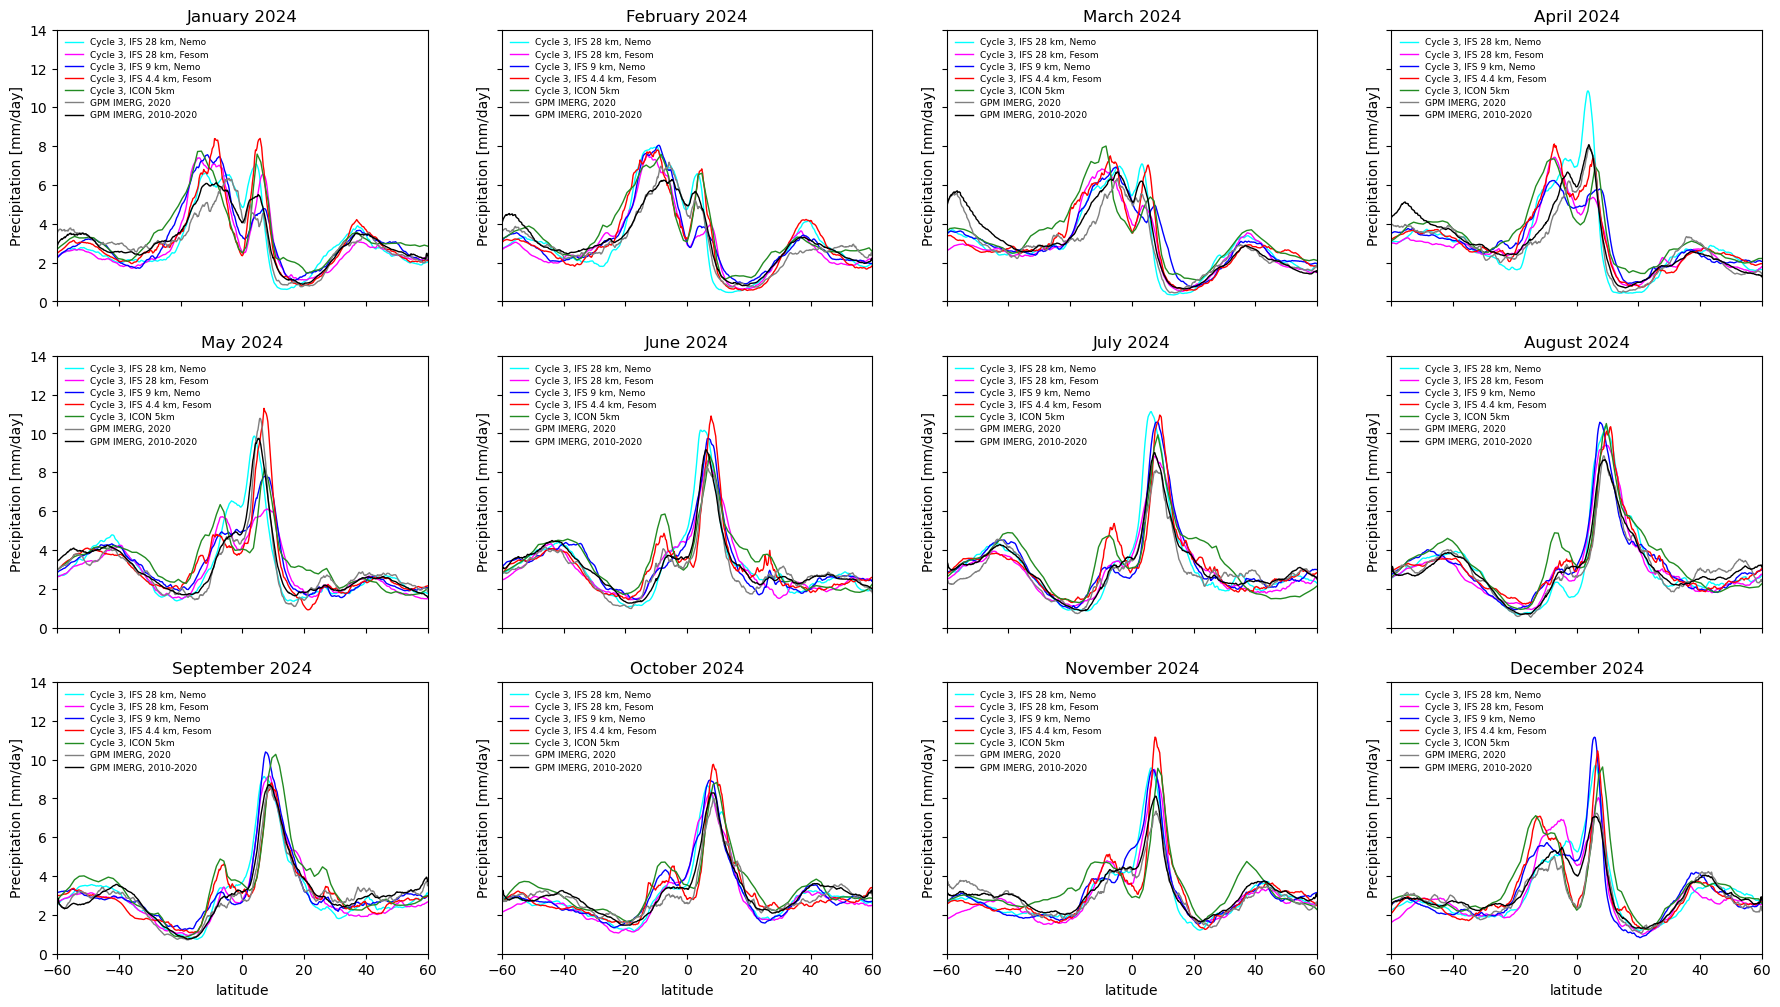

In [18]:
# calendar plot for each year separately

for y,yea in enumerate(array_yea):  
  
  Title= [f'January {yea}',f'February {yea}',f'March {yea}',f'April {yea}',f'May {yea}',f'June {yea}',f'July {yea}',f'August {yea}',f'September {yea}',f'October {yea}',f'November {yea}',f'December {yea}']
  
  fig, axs = plt.subplots(3,4, figsize=(22, 12), sharex=True, sharey=True)

  # set labels
  plt.setp(axs[-1], xlabel='latitude') # only plot this for the last element
  plt.setp(axs[:], ylabel='Precipitation [mm/day]')
  plt.setp(axs[:], xlim=(-60, 60))
  plt.setp(axs[:], ylim=(0, 14))


  for mon,(i,ax) in zip(array_mon,enumerate(axs.flat)):  
     #print(mon)
     ax.set_title(Title[i])

     for (a,exp),color,labels in zip(enumerate(array_exp),array_color,array_labels):        
         filP = dask_dict[a,i] *1000 *86400 #transform from m/s in mm/day ; first dimension is experiment, second dimension is month
         if len(filP[:,0]) > y:
              filP_y=np.squeeze(filP[y,:])
              ax.plot(filP_y.lat,
                   filP_y.data,
                   color=color,
                   linestyle='solid',
                   label=labels,
                   linewidth=1)
            
     ICON_y=np.squeeze(ICON_dict[y,i])
     labels="Cycle 3, ICON 5km"           
     ax.plot(ICON_y.lat,
                   ICON_y,
                   color="forestgreen",
                   linestyle='solid',
                   label=labels,
                   linewidth=1)  
    
     ax.plot(PrG[i].lat,
          PrG[i].data,
          color="grey",
          linestyle='solid',
          label="GPM IMERG, 2020",
          linewidth=1)

     ax.plot(PrGclim[i].lat,
          PrGclim[i].data,
          color="black",
          linestyle='solid',
          label="GPM IMERG, 2010-2020",
          linewidth=1)    
    

     # Add legend
     handles, labels = ax.get_legend_handles_labels()
     ax.legend(handles,
      labels,
      loc='upper left',
      frameon=False,
      fontsize=6.5,
      labelspacing=.35)
        
  
     #fig.savefig(f'../../../scripte_plots/panel12_precip_zonmean_NextGEMS_Cycle3_4km_9km_28km_ICON_GPM_{yea}.png')  
     #fig.savefig(f'../../../scripte_plots/panel12_precip_zonmean_NextGEMS_Cycle3_4km_9km_28km_ICON_GPM_{yea}.pdf')      